<a href="https://colab.research.google.com/github/taikarir/plant-identifier/blob/main/plant_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# allows graphs to be displayed
%matplotlib inline
# importing required modules
from google.colab import drive
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import random
import math
# import time
import IPython
import pickle
# import os
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import repeat

# directory/file paths we will be using
directory = "/content/drive/"
folder_path = "drive/MyDrive/plant_id_project/"

In [ ]:
# this function plots data given
def plotxy(x, y, func=plt.scatter, title="Training Loss Over Time", xlabel="Iters", ylabel="Loss"):
    func(x, y);
    plt.title(title);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoHeight;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [ ]:
label_Id = {"Maple":1,"Peach":2,"Norway Spruce":3,"Apple":4,"Hydrangea":5,"Cherry":6,"Colorado Spruce":7,"Japanese Maple":8,"Rose":9,"Boxwood":10,"Tomato":11,"Dandelion":12}

# loads image data for certain classes
def load_data(classes):
    if classes == "all":
        classes = [i for i in label_Id]
    collected = []
    for i in classes:
        matching = plant_data.loc[plant_data["Label"]==i]["Image"]
        for j in matching:
            collected.append(j)
    collected = np.transpose(collected)
    theshape = np.shape(collected)
    collected = np.reshape(collected, (theshape[0]*theshape[1],theshape[2]))
    return collected

# encodes data for certain classes
def encode_data(classes, encoding):
    if classes == "all":
        classes = [i for i in label_Id]
    if encoding == "one-hot":
        s_encoding = []
        for i in range(0,len(classes)):
            s_encoding.append(np.zeros(len(classes)))
            s_encoding[i][i] = 1
    if encoding == "one-hot":
        class_vectors = [list(repeat(s_encoding[i],len(plant_data.loc[plant_data["Label_Id"]==i+1]))) for i in range(0,len(classes))]
    else:
        # class_vectors = [encoding[i]*np.ones(len(plant_data.loc[plant_data["Label"]==classes[i]])) for i in range(0,len(classes))]
        class_vectors = []
        for i in range(0,len(classes)):
            for j in range(0,len(plant_data.loc[plant_data["Label"]==classes[i]])):
                class_vectors.append([encoding[i]])
    class_vector = np.concatenate(class_vectors,axis=0)
    return class_vector

# loads weights and biases from external files
def load_values(x):
    with open(folder_path+x, "rb") as f:
        f1 = pickle.load(f)
    return f1

In [ ]:
# plant_data = pd.read_csv(folder_path + "plant_data_2.csv")    # reading the csv with the plant data
# plant_data_label = plant_data["Label_Id"]                     # selecting the label rows from plant_data
# pix = []

# opens each image file and replaces the text with pixel data
# for _,i in enumerate(plant_data["Image"]):
#     img = Image.open(folder_path + "processed_imgs_2/" + i)
#     pix.append(list(img.getdata()))
#     plant_data["Image"][_] = pix[_]
#     print(_)
# with open(folder_path+"pixel_data_2.pkl","wb") as f:
#     pickle.dump(pix, f, pickle.HIGHEST_PROTOCOL)

# loads pixel data for the images
# pix_data = load_values("pixel_data_2.pkl")
# for i in range(0,len(plant_data["Image"])):
#     plant_data["Image"][i] = pix_data[i]

# with open(folder_path+"full_plant_data.pkl","wb") as f:
#     pickle.dump(plant_data, f, pickle.HIGHEST_PROTOCOL)
plant_data = load_values("full_plant_data.pkl")

In [ ]:
img = Image.open(folder_path + "processed_imgs_2/plant1.jpg")
img2 = img.rotate(15);
img2data = list(img2.getdata())
img2vector = np.reshape(img2data,(189*189,3))
for _,i in enumerate(img2vector):
    if i[0]==0 and i[1]==0 and i[2]==0:
        x_pos = _%189
        y_pos = math.floor(_/189)
        if y_pos<(189/2-x_pos) or y_pos<(-189/2+x_pos) or y_pos>(189/2+x_pos) or y_pos>(3*189/2-x_pos):
            img2vector[_] = (175,175,175)
img2data = np.reshape(img2vector,(189,189,3))
img3 = img.crop((50,50,139,139))
plt.imshow(img2data);
plt.show();
plt.imshow(img3);
plt.show();
plt.imshow(img);

In [ ]:
# DO NOT RUN
# generates rotated and scaled images
n_samp = np.shape(x_train)[1]
print(np.shape(x_train))
id = []
pixs = []
for i in range(0,30):
    randsamp = random.randrange(0,n_samp)
    ip = np.array(x_train)[:,randsamp]
    id.append(np.array(y_train)[randsamp])
    ip = np.reshape(ip, (189,189,3), order="F")
    ip = np.rot90(ip, axes=(1,0))
    ip = np.fliplr(ip)
    ip = Image.fromarray(np.uint8(ip))
    rotat = random.randrange(-8,9)
    ip = ip.rotate(rotat)
    ip.save(folder_path+"rotated_imgs/plant{}.jpg".format(i))
    pixs.append(list(ip.getdata()))
    print(i)
    # plt.imshow(ip);
    # plt.show();
with open(folder_path+"rotated_imgs_class.pkl","wb") as f:
    pickle.dump(id, f, pickle.HIGHEST_PROTOCOL)
with open(folder_path+"rotated_imgs_pixel_data.pkl","wb") as f:
    pickle.dump(pixs, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# splits data into training and testing
def split_train_test(data, encoding, frac, seed):
    data = np.array(data)
    n_samples = np.shape(data)[1]
    n_train = round(frac * n_samples)
    np.random.seed(seed)
    indeces = np.random.permutation(n_samples)
    train_indeces = indeces[0:n_train]
    test_indeces = indeces[n_train:]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for i in train_indeces:
        x_train.append(data[:,i])
        y_train.append(encoding[i])
    for i in test_indeces:
        x_test.append(data[:,i])
        y_test.append(encoding[i])
    x_train = np.transpose(x_train)
    x_test = np.transpose(x_test)
    return x_train, x_test, y_train, y_test

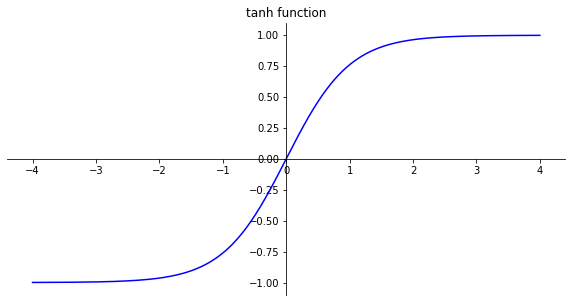

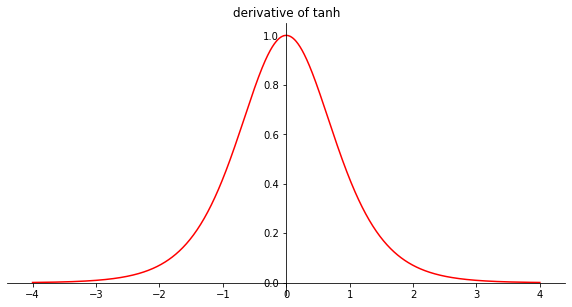

In [ ]:
def linear(z):                           # linear activation
    return z
def dlinear(z):                          # derivative of linear
    return 1.0
def tanh(z):                             # tanh activation
    return (np.power(math.e,(2*z))-1)/(np.power(math.e,(2*z))+1)
def dtanh(z):                            # derivative of tanh
    return 1 - tanh(z)**2
def sigmoid(z):                          # sigmoid activation
    return 1/(1+np.power(math.e,-x))
def dsigmoid(z):                         # derivative of sigmoid
    return sigmoid(z)*(1-sigmoid(z))

# output of a single neuron
def f1(x, w, b, f_a):
    ans = [f_a(w * x[i] + b * np.ones(np.size(x[i]))) for i in range(0,len(x))]
    return ans

# output of neuron with multi-dimensional inputs
def gn(x, w, b, f_a):
    w = np.reshape(w, [len(w),1])
    ans = f_a(np.dot(np.transpose(x),w) + b*np.ones([np.shape(x)[1],1]))
    return ans

def gn_1layer(x, w, b, f_a):
    #w = np.reshape(w, [189*189*3,5])
    #b = np.reshape(b, [len(b),1])
    N = np.shape(x)[1]
    ans = np.zeros((N,5))
    for i2 in range(0,N):
        for j2 in range(0,5):
            ans[i2][j2] = f_a(np.dot(np.transpose(w[j2,:]),x[:,i2]) + b[j2])
    return ans

def set_axs_graph(ax):
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

xplot = np.linspace(-4, 4, 1000)
yplot1 = tanh(xplot)
yplot2 = dtanh(xplot)
# asymptote1 = np.ones(1000)
# asymptote2 = -np.ones(1000)

fig = plt.figure(figsize=(10,5));
ax = fig.add_subplot(1,1,1);
set_axs_graph(ax)
plt.plot(xplot, yplot1, "b");
plt.title("tanh function");

fig = plt.figure(figsize=(10,5));
ax = fig.add_subplot(1,1,1);
set_axs_graph(ax)
plt.plot(xplot, yplot2, "r");
plt.title("derivative of tanh");

plt.show();

In [ ]:
# finds the current loss of the model
def grad_loss(f_a, df_a, x, y, w, b, normalize=True):
    dw = np.zeros(len(w))
    db = 0.0
    loss = 0.0
    for j in range(0, np.shape(x)[1]):
       error = y[j] - f_a(np.dot(np.transpose(w),x[:,j]) + b)
       common_term = error * df_a(np.dot(np.transpose(w),x[:,j]) + b)
       dw = dw - 2.0 * common_term * x[:,j]
       db = db - 2.0 * common_term
       loss += error**2
    if normalize:
       dw /= len(y)
       db /= len(y)
       loss /= len(y)
    return dw, db, loss

def grad_loss_1layer(f_a, df_a, x, y, w, b):
    n, d = np.shape(w)
    N = np.shape(y)[0]
    dw = np.zeros((n,d))
    db = np.zeros(n)
    loss = 0.0
    for i2 in range(0,N):
        for j2 in range(0,n):
            eval = f_a(np.dot(np.transpose(w[j2,:]),x[:,i2]) + b[j2])
            error = y[i2][j2] - eval
            common_term = error * df_a(np.dot(np.transpose(w[j2,:]),x[:,i2]) + b[j2])
            for q in range(0,d):
                dw[j2][q] = dw[j2][q] - 2/N * common_term * x[q][i2]
            db[j2] = db[j2] - 2/N * common_term
            loss += 1/N * error**2
    return dw, db, loss


def grad_loss_1layer_1output(f_a, df_a, x, y, w, b):
    n, d = np.shape(w)
    N = np.shape(x)[1]
    dw = np.zeros((n,d))
    db = np.zeros(n)
    loss = 0.0
    for i in range(0,N):
        error = y[i] - f_a(np.dot(np.transpose(w[i]),x[:,i]) + b)
        for j in range(0,n):
            common_term = error * df_a(np.dot(np.transpose(w[j,:]),x[:,i]) + b[j])
            for q in range(0,d):
                dw[j][q] = dw[j][q] - 2/N * common_term * x[q][i]
            db[j] = db[j] - 2/N * common_term
            loss += 1/N * error**2
    return dw, db, loss

In [ ]:
# this function optimizes a model using the gradient descent method
def grad_descent(f_a, df_a, grad_loss, x, y, w, b, mu, iters, loss, show_loss=True, normalize=True, seed=0):
    n = np.shape(x)[0]
    if type(w)==int:
        if seed == False:             # either starts with weights at 0...
            w = np.zeros(n)
            b = 0.0
        else:                         # ...or gives random starting values
            random.seed(seed)
            w = np.random.randn(n)
            b = np.random.randn()
    prevlen = len(loss)
    for i in range(0,iters):
        loss = np.append(loss, 0)
    # print(len(loss))
    for i in range(0,iters):      # runs for a set amount of iterations
        loss_i = 0
        N = np.shape(y)[0]
        dw, db, loss_i = grad_loss(f_a, df_a, x, y, w, b)
        w = w - mu * dw           # learning rate mu determines how fast it learns
        b = b - mu * db
        loss[i+prevlen] = loss_i
        print("\nIter ",i+prevlen+1,": \t\t",loss[i+prevlen])
        if show_loss:
            if ((i+1)%10)==0:
                xx = range(0,prevlen+i)
                yy = loss[0:prevlen+i]
                plotxy(xx, yy)
                # mm, bb = np.polyfit(xx, yy, 1)
                # plt.plot(xx, mm*xx+bb);
                plt.show();
    print("\n\n*============*\n\n")
    print("Final Loss: ",loss[-1])
    plotxy(range(0,len(loss)),loss)
    return w, b, loss

# this function optimizes a model using the stochastic gradient descent method
def sto_grad_descent(f_a, df_a, grad_loss, x, y, mu=0.001, iters=500, batch_size=10, show_loss=True, normalize=True, seed=1):
    n, N = np.shape(x)
    if seed == False:             # starts with the same random numbers each time
        random.seed(1)
        w = np.zeros(n)
        b = 0.0
    else:
        random.seed(seed)
        w = np.random.randn(n)
        b = np.random.randn()
    loss = np.zeros(iters)
    for i in range(0,iters):      # runs for a set amount of iterations
        batch_idx = np.random.permutation(N)
        batch_idx = batch_idx[0:min(batch_size,N)]
        dw, db, loss_i = grad_loss(f_a, df_a, x[:,batch_idx], y[batch_idx], w, b, normalize)
        w = w - mu * dw           # learning rate mu determines how fast it learns
        b = b - mu * db
        loss[i] = loss_i
        if show_loss:
            if ((i+1)%100)==0:
                print("\nIter ",i+1,": \t\t",loss[i])
                plotxy(range(0,i),loss[0:i])
    print("\n\n*============*\n\n")
    print("Final Loss: ",loss[-1])
    plotxy(range(0,iters),loss)
    return w, b, loss

# this function optimizes a model using the accelerated stochastic gradient descent method
def acc_sto_grad_descent(f_a, df_a, grad_loss, x, y, mu=0.001, iters=500, batch_size=10, show_loss=True, normalize=True, seed=1):
    n, N = np.shape(x)
    if seed == False:
        w = np.zeros(n)
        b = 0.0
    else:
        random.seed(seed)
        w = np.random.randn(n)
        b = np.random.randn()
    loss = np.zeros(iters)
    lambdak = 0
    qk = w
    pk = b
    for i in range(0,iters):         # runs for a set amount of iterations
        batch_idx = np.random.permutation(N)
        batch_idx = batch_idx[0:min(batch_size,N)]
        dw, db, loss_i = grad_loss(f_a, df_a, x[:,batch_idx], y[batch_idx], w, b)
        qkp1 = w - mu * dw           # learning rate mu determines how fast it learns
        pkp1 = b - mu * db
        lambdakp1 = (1 + np.sqrt(1 + 4 * lambdak**2)) / 2
        gammak = (1 - lambdak) / (lambdakp1)
        w = (1 - gammak) * qkp1 + gammak * qk
        b = (1 - gammak) * pkp1 + gammak * pk
        qk = qkp1
        pk = pkp1
        lambdak = lambdakp1
        loss[i] = loss_i
        if show_loss:
            if ((i+1)%100)==0:
                print("\nIter ",i+1,": \t\t",loss[i])
                plotxy(range(0,i),loss[0:i])
    print("\n\n*============*\n\n")
    print("Final Loss: ",loss[-1])
    plotxy(range(0,iters),loss)
    return w, b, loss

def asgd_1layer(f_a, df_a, grad_loss, x, y, w, b, mu, iters, batch_size, show_loss=False):
    d = np.shape(w)[1]
    n = np.shape(w)[1]
    N = np.shape(x)[1]

    loss = np.zeros(iters)
    lambda_k = 0
    q_k = w
    p_k = b
    for i in range(0,iters):
        batch_idx = np.random.permutation(N)
        batch_idx = batch_idx[0:min(batch_size,N)]
        dW, db, loss_i = grad_loss(f_a, df_a, x[:,batch_idx], y[batch_idx], w, b)
        q_kp1 = w - mu*dW
        p_kp1 = b - mu*db
        lambda_kp1 = (1 + np.sqrt(1 + 4 * lambda_k**2)) / 2
        gamma_k = (1 - lambda_k) / (lambda_kp1)
        w = (1 - gamma_k) * q_kp1 + gamma_k * q_k
        b = (1 - gamma_k) * p_kp1 + gamma_k * p_k
        q_k = q_kp1
        p_k = p_kp1
        lambda_k = lambda_kp1
        loss[i] = loss_i
        if show_loss:
            if ((i+1)%10)==0:
                print("\nIter ",i+1,": \t\t",loss[i])
                xx = range(0,i)
                yy = loss[0:i]
                plotxy(xx, yy)
                mm, bb = np.polyfit(xx, yy, 1)
                plt.plot(xx, mm*xx+bb);
                plt.show();
    print("\n\n*============*\n\n")
    print("Final Loss: ",loss[-1])
    plotxy(range(0,iters),loss)
    return w, b, loss

In [ ]:
train_test_frac = 0.7               # fraction of data that will be for training
encoding = [-1, -0.5, 0, 0.5, 1]    # encodings for image classes

# loading the classes we will be using
classes = ["Hydrangea", "Apple", "Colorado Spruce", "Peach", "Maple"]
x = load_data(classes)
y = encode_data(classes, encoding)

# loads pre-trained weights or starts over
# w_hat = load_values("w_hat_train.pkl")
# b_hat = load_values("b_hat_train.pkl")
# w_hat = np.zeros((len(classes),189*189*3))
# b_hat = np.zeros(len(classes))

# splits data into training and testing
# x_train, x_test, y_train, y_test = split_train_test(x, y, train_test_frac, 0)
# mu = 0.0000000001                   # learning rate mu
# batch_size = 60                     # batch size (only for stochastic grad-desc)
# iters = 20000                       # number of iterations

# training the model
# %time w_hat, b_hat, loss = grad_descent(tanh, dtanh, grad_loss, np.array(x_train), np.array(y_train), w_hat, b_hat, mu, iters, batch_size, True)
# with open(folder_path+"w_hat_train_2.pkl", "wb") as f:
#     pickle.dump(w_hat, f, pickle.HIGHEST_PROTOCOL)
# with open(folder_path+"b_hat_train_2.pkl", "wb") as f:
#     pickle.dump(b_hat, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
train_test_frac = 0.7
# encoding = {"Hydrangea":[1,0,0,0,0],"Apple":[0,1,0,0,0],"Colorado Spruce":[0,0,1,0,0],"Peach":[0,0,0,1,0],"Maple":[0,0,0,0,1]}
encoding = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]
classes = ["Hydrangea", "Apple", "Colorado Spruce", "Peach", "Maple"]

x = load_data(classes)
y = encode_data(classes, encoding)
# print(np.shape(y))
# print(y)

w_hat_linear = load_values("w_linear_test.pkl")
b_hat_linear = load_values("b_linear_test.pkl")
loss_hat_linear = load_values("loss_linear_test.pkl")
# w_hat_linear = np.zeros((5, 107163))
# b_hat_linear = np.zeros((5))
# print(len(loss_hat_linear))
print(loss_hat_linear[-1])

x_train, x_test, y_train, y_test = split_train_test(x, y, train_test_frac, 0)
mu = 10e-11
iters = 100
# batch_size = 10
# %time w_linear, b_linear, loss_linear = grad_descent(tanh, dtanh, grad_loss_1layer, np.array(x_train), np.array(y_train), w_hat_linear, b_hat_linear, mu, iters, loss_hat_linear, True)
# with open(folder_path+"w_linear_test.pkl", "wb") as f:
#     pickle.dump(w_linear, f, pickle.HIGHEST_PROTOCOL)
# with open(folder_path+"b_linear_test.pkl", "wb") as f:
#     pickle.dump(b_linear, f, pickle.HIGHEST_PROTOCOL)
# with open(folder_path+"loss_linear_test.pkl", "wb") as f:
#     pickle.dump(loss_linear, f, pickle.HIGHEST_PROTOCOL)

0.29391912079055965


[-0.12673237  1.02756403]


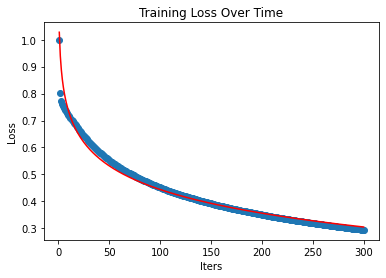

In [ ]:
xfit = range(1,len(loss_linear)+1)
yfit = loss_linear
plotxy(xfit, yfit)
fit = np.polyfit(np.log(xfit), yfit, 1)
print(fit)
def logx(x, fit):
    return fit[1]+fit[0]*np.log(x)
plt.plot(xfit, logx(xfit, fit), "r")
plt.show();

(5, 107163)


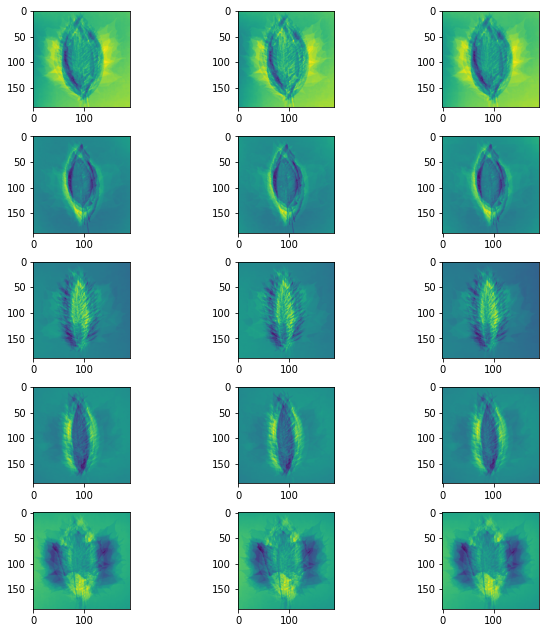

In [ ]:
w_linear = load_values("w_linear.pkl")
b_linear = load_values("b_linear.pkl")
print(np.shape(w_linear))
w_linear_matrix = np.reshape(w_linear,(len(classes),3,189,189))
fig, axs = plt.subplots(5,3,figsize=(11,11))
for i in range(0,len(classes)):
    for j in range(0,3):
        # axs[i, j].imshow(w_linear_matrix[i][j], origin={"upper"}, alpha=1.0);
        axs[i, j].imshow(w_linear_matrix[i][j]);
        # plt.figure(figsize=(5,5));
        # plt.colorbar(axs[i][j]);
        # plt.gca().invert_yaxis();
    plt.subplots_adjust(wspace=0, hspace=0.3)
# y_linear = gn(x_test, w_linear, b_linear, tanh)
# plt.scatter(range(0,len(y_linear),y_linear))

# w_hat = load_values("w_hat_train.pkl")
# b_hat = load_values("b_hat_train.pkl")

# # plots predicted values against actual encodings
# y_hat = gn(x_test, w_hat, b_hat, tanh)
# plt.scatter(range(0,len(y_hat)), y_hat);
# plt.scatter(range(0,len(y_test)), y_test);
# plt.show();

# # plots the weights for each data value (1 for each R, G, B)
# w_hat_matrix = np.reshape(w_hat, (3, 189, 189))
# for i in range(0,3):
#     plt.subplot(1, 3, i+1)
#     _=plt.imshow(w_hat_matrix[i], origin={"upper"}, alpha=1.0);
#     plt.colorbar(_);
#     plt.gca().invert_yaxis();
# plt.subplots_adjust(right=2)

In [ ]:
# counts all the images that were incorrectly classified
y_linear = gn_1layer(x_test, w_linear, b_linear, tanh)
predicted_labels = []

for i in range(0,len(y_test)):
    aa = [0,0,0,0,0]
    pred = y_linear[i]
    aa[np.argmax(pred)] = 1
    predicted_labels.append(aa)

n_wrong = 0
end_imgs = []
for i in range(0,len(y_test)):
    imag = np.reshape(x_test[:,i], (189,189,3), order="F")
    imag = np.rot90(imag, axes=(1,0))
    imag = np.fliplr(imag)
    end_imgs.append(imag)
    if np.argmax(y_test[i]) != np.argmax(predicted_labels[i]):
        n_wrong +=1

def show_all(x):
    fig, axs = plt.subplots(1, 2, figsize=(15,5));
    axs[0].imshow(end_imgs[x]);
    # plt.show();
    max = np.argmax(y_linear[x])
    _=axs[1].bar(classes, y_linear[x], width=0.8);
    _[max].set_color("r")
    plt.show();
interact(show_all, x=(0, len(end_imgs)-1))

# graph_preds = [np.argmax(predicted_labels[i]) for i in range(0,len(y_test))]
# graph_ytest = [np.argmax(y_test[i]) for i in range(0,len(y_test))]

# gpreds = plt.scatter(range(0,len(y_test)), graph_ytest, alpha=1.0, marker="o")
# gytest = plt.scatter(range(0,len(y_test)), graph_preds, alpha=1.0, marker=".")
# plt.legend(handles=[gpreds,gytest],labels=["Predicted","Actual"])
# plt.title("Predicted Labels vs Actual Labels")
# plt.xlabel("sample #")
# plt.ylabel("class #")
# plt.text(0, -1, ("Percent correct: " + str(round((len(y_test)-n_wrong)/len(y_test)*100,2)) + "%"));
# plt.show();



# print(y_linear)
# predicted_labels = []
# for i in range(0,len(y_test)):
#     predicted_labels.append(min(encoding, key=lambda x_test:abs(x_test-y_hat[i])))
# n_wrong = 0
# wrong_imgs = []
# wrong_pred = []
# for i in range(0,len(y_test)):
#     if y_test[i] != predicted_labels[i]:
#         imag = np.reshape(x_test[:,i], (189,189,3), order="F")
#         imag = np.rot90(imag, axes=(1,0))
#         imag = np.fliplr(imag)
#         wrong_imgs.append(imag)
#         wrong_pred.append(classes[encoding.index(predicted_labels[i])])
#         n_wrong += 1

# def show_wrong(x):
#     plt.imshow(wrong_imgs[x]);
#     plt.show();
#     print("Classified as {}".format(wrong_pred[x]))
# interact(show_wrong, x=(0,len(wrong_imgs)-1))

# # plots actual value against rounded predicted value
# preds=plt.scatter(range(0,len(y_test)), y_test, alpha=1.0, marker="o");
# actual=plt.scatter(range(0,len(y_test)), predicted_labels, alpha=1.0, marker=".");
# plt.legend(handles=[preds,actual],labels=["Predicted","Actual"])
# plt.title("Predicted Labels vs Actual Labels")
# plt.xlabel("sample #")
# plt.ylabel("encoding")
# plt.text(0, -1, ("Percent correct: " + str(round((len(y_test)-n_wrong)/len(y_test)*100,2)) + "%"));
# plt.show();
# print("Percent correct: " + str(round((len(y_test)-n_wrong)/len(y_test)*100,2)) + "%")

interactive(children=(IntSlider(value=9, description='x', max=18), Output()), _dom_classes=('widget-interact',…

<function __main__.show_all>

In [ ]:
rot_actual_labels = load_values("rotated_imgs_class.pkl")
rot_predicted_labels = []
n_rotated = len(rot_actual_labels)
y_linear_rot = []
end_imgs_rot = []
end_values_rot = load_values("rotated_imgs_pixel_data.pkl")
print(np.shape(end_values_rot))
# for _ in range(0,n_rotated):
#     new_img = Image.open(folder_path+"rotated_imgs/plant{}.jpg".format(_))
#     new_img = new_img.resize((189,189))
#     pixels = list(new_img.getdata())
#     end_values_rot.append(pixels)

end_values_rot = np.reshape(end_values_rot, (35721, 3, n_rotated), order="C")
end_values_rot = np.reshape(end_values_rot, (3*35721, n_rotated), order="C")
print(end_values_rot[0])
y_linear_rot = gn_1layer(end_values_rot, w_linear, b_linear, tanh)
n_wrong_rot = 0

graph_preds_rot = [np.argmax(y_linear_rot[i]) for i in range(0,n_rotated)]
graph_ytest_rot = [np.argmax(rot_actual_labels[i]) for i in range(0,n_rotated)]
# print(graph_ytest_rot)
# print(y_linear_rot)
for i in range(0,n_rotated):
    # print(rot_actual_labels[i])
    # # print(np.shape(end_values_rot[:,i]))
    # print(gn_1layer(np.reshape(end_values_rot[:,i], (3*35721,1)), w_linear, b_linear, tanh))
    imag = np.reshape(end_values_rot[:,i], (189,189,3), order="C")
    imag = np.rot90(imag, axes=(1,0))
    imag = np.fliplr(imag)
    end_imgs_rot.append(imag)
    aa = [0,0,0,0,0]
    aa[np.argmax(y_linear_rot[i])] = 1
    rot_predicted_labels.append(aa)
    if graph_preds_rot[i]!=graph_ytest_rot[i]:
        n_wrong_rot += 1

def show_all(x):
    fig, axs = plt.subplots(1, 2, figsize=(15,5));
    axs[0].imshow(end_imgs_rot[x]);
    # imag = end_values_rot[:,x]
    # print(np.shape(imag))
    # imag = np.reshape(imag, (189,189,3), order="F")
    # axs[0].imshow(imag)
    # print(np.shape(end_imgs_rot))
    # plt.show();
    max = np.argmax(y_linear_rot[x])
    _=axs[1].bar(classes, y_linear_rot[x], width=0.8);
    _[max].set_color("r")
    plt.show();
interact(show_all, x=(0, n_rotated-1))

# print((n_rotated-n_wrong_rot)/n_rotated)

gpreds = plt.scatter(range(0,n_rotated), graph_ytest_rot, alpha=1.0, marker="o")
gytest = plt.scatter(range(0,n_rotated), graph_preds_rot, alpha=1.0, marker=".")
plt.legend(handles=[gpreds,gytest],labels=["Predicted","Actual"])
plt.title("Predicted Labels vs Actual Labels (Rotated Images)")
plt.xlabel("sample #")
plt.ylabel("class #")
plt.text(0, -1, ("Percent correct: " + str(round((n_rotated-n_wrong_rot)/n_rotated*100,2))) + "%");
plt.show();

<IPython.core.display.Javascript object>

Saved to photo.jpg


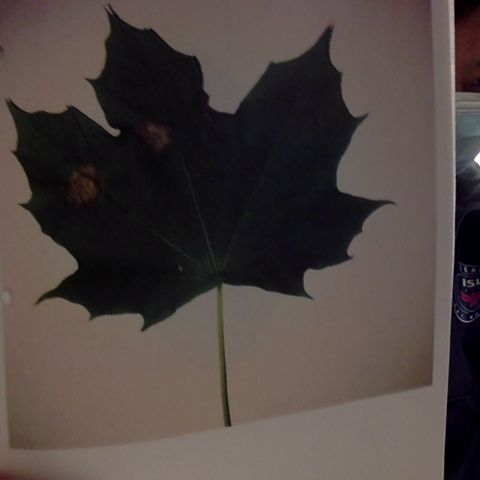

In [ ]:
from IPython.display import Image as IImage
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
  
    # Show the image which was just taken.
    display(IImage(filename))
except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

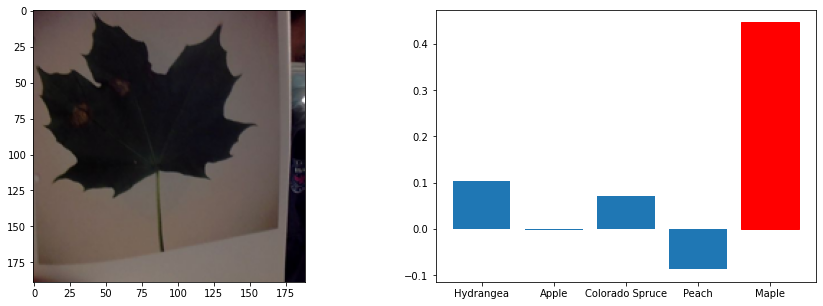

In [ ]:
new_img = Image.open("photo.jpg")
new_img = new_img.resize((189,189))
pixels = list(new_img.getdata())
fig, axs = plt.subplots(1, 2, figsize=(15,5));
axs[0].imshow(np.reshape(pixels, (189,189,3)));
final_img = np.reshape(pixels, (189*189*3,1), order="F")
y_hat_img = gn_1layer(final_img, w_linear, b_linear, tanh)
max = np.argmax(y_hat_img)
_=axs[1].bar(classes,np.reshape(y_hat_img,(5)), width=0.8);
_[max].set_color("r")
plt.show();

In [ ]:
# dumping weights and bias into file that can be retrieved instead of retraining model
with open(folder_path+"w_linear.pkl", "wb") as f:
    pickle.dump(w_linear, f, pickle.HIGHEST_PROTOCOL)
with open(folder_path+"b_linear.pkl", "wb") as f:
    pickle.dump(b_linear, f, pickle.HIGHEST_PROTOCOL)